# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally. 

In [1]:
#!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [2]:
#!pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [4]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [5]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2025-03-11 11:36:36--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 100.64.1.31
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|100.64.1.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0.06s   

2025-03-11 11:36:37 (334 KB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2025-03-11 11:36:37--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 100.64.1.31
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|100.64.1.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14747 (14K) [text/plain]
Saving to: ‘john_wick_2.csv’

john_wick_2.csv     100%[===================>]  14.40K  --.-KB/s   

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [6]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [7]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 3, 8, 11, 36, 50, 400065)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [8]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [9]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [10]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-3.5-turbo` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [11]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI()

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [12]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [13]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Yes, people generally liked John Wick. The reviews praised the action sequences, Keanu Reeves' performance, and the overall entertainment value of the film."

In [14]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is a review with a rating of 10. Here is the URL to that review:\n- Review: A Masterpiece & Brilliant Sequel\n- URL: '/review/rw4854296/?ref_=tt_urv'"

In [15]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie John Wick, an ex-hitman comes out of retirement seeking vengeance after gangsters kill his dog and steal his car. With his lethal skills, he faces off against Russian mobsters and hoodlums who are aware of his capacity for violence. As a result, John Wick embarks on a relentless vendetta filled with action-packed scenes and intense confrontations.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [16]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [17]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [18]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"People's opinions on John Wick vary. Some may have liked it for its action and stylish stunts, while others may have found it boring and full of stereotypes. It ultimately depends on individual tastes and preferences."

In [19]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I'm sorry, none of the reviews provided have a rating of 10."

In [20]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'John Wick is a highly recommended action movie with beautifully choreographed action, emotional setup, and Keanu Reeves. It is considered a great action movie by many viewers.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [21]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [22]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [23]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Yes, people generally liked John Wick. The reviews mentioned that it was an excellent action film with slickness in Keanu Reeves' performance, brilliant action sequences, a well-paced plot, and an overall entertaining experience."

In [24]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'There is one review with a rating of 10 for the movie "John Wick 3". Here is the URL to that review: /review/rw4854296/?ref_=tt_urv.'

In [25]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, the protagonist, John Wick, is drawn back into the world of assassins when he is forced to carry out a hit by a mobster named Santino D'Antonio. After completing the task, John Wick becomes the target of a contract put out on him by Santino, leading to a series of intense confrontations."

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [26]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [27]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [28]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Yes, people generally liked John Wick based on the reviews provided. The film was praised for its slickness, brilliant action sequences, Keanu Reeves' performance, and overall entertainment value."

In [29]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review: `/review/rw4854296/?ref_=tt_urv`.'

In [30]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the John Wick movies, Keanu Reeves plays John Wick, a retired assassin who comes out of retirement for various reasons, including seeking revenge for the death of his dog and the theft of his car. John Wick gets involved in a lot of action and kills numerous people throughout the movies.'

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [31]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [32]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

/tmp/ipykernel_66608/3574430551.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [33]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [34]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [35]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [36]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Some people liked John Wick, while others did not. It seems to vary based on personal preferences.'

In [37]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3". Here is the URL for the review: /review/rw4854296/?ref_=tt_urv'

In [38]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the John Wick movies, John Wick, a retired assassin, gets pulled back into the world of killing when his dog is killed and his car is stolen. He goes on a mission of revenge, taking on various enemies and assassins along the way. In John Wick 2, he is forced to accept a job that leads to more action and violence in various locations like Italy, Canada, and Manhattan. The movies are known for their intense action sequences and high body count.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [39]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [40]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [41]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Overall, the majority of reviews and ratings indicate that people generally liked John Wick. The film was praised for its action sequences, Keanu Reeves' performance, and the stylishness of the movie. Reviewers highlighted the fluidity of the action, the fun factor, and the unique world portrayed in the movie. While there were a couple of negative reviews, the overall sentiment seems to be positive towards John Wick."

In [42]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for "John Wick 3" by the author \'ymyuseda\'. Here is the URL to that review: \'/review/rw4854296/?ref_=tt_urv\'.'

In [43]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, an ex-hit-man comes out of retirement to track down the gangsters that killed his dog and took everything from him. Seeking vengeance for the death of his wife, John Wick finds himself dragged into a dangerous task as every killer in the business wants to corner the legendary Wick, who now has a bounty on his head. The movie is filled with lots of intense action, shootouts, and breathtaking fights as John Wick seeks retribution for the harm done to him.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [44]:
#!pip install -qU langchain_experimental

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [45]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [46]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [47]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [48]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [49]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [50]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, it seems that the majority of people liked John Wick.'

In [51]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n- /review/rw4854296/?ref_=tt_urv'

In [52]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, the main character seeks revenge on the people who took something he loved from him, in this case, his dog. He is an ex-hitman who comes out of retirement to track down the gangsters responsible for killing his dog and taking everything from him. It's a story of vengeance and action-packed chaos."

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

### Create Golden Dataset using SDG

In [172]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.testset import TestsetGenerator

sdg_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
sdg_embedding_model = LangchainEmbeddingsWrapper(embeddings)
gd_generator = TestsetGenerator(llm=sdg_llm, embedding_model=sdg_embedding_model)
synthetic_golden_dataset = gd_generator.generate_with_langchain_docs(documents, testset_size=10)

Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Node 776c0386-0aea-4596-97c6-33aad3cc68f1 does not have a summary. Skipping filtering.
Node 4e84de00-f68d-42cc-b1ef-bdc004353f2b does not have a summary. Skipping filtering.
Node dc381808-0b09-48c9-a735-975ab9265908 does not have a summary. Skipping filtering.
Node 7302e568-002a-46e0-b874-4337ce2bdf85 does not have a summary. Skipping filtering.
Node f0c229f8-638c-4e25-bf53-2c61269a910c does not have a summary. Skipping filtering.
Node 456f96ad-b6cb-466e-a154-03530fbbb1e1 does not have a summary. Skipping filtering.
Node 6026c67a-10c9-4b99-ba7e-77815edc5ca0 does not have a summary. Skipping filtering.
Node b71c6157-f590-4c00-b89a-fee4be70c088 does not have a summary. Skipping filtering.
Node 0e4e0c1c-07dc-4eda-932d-1bfb7bf217c8 does not have a summary. Skipping filtering.
Node 689917ca-ecb3-49ff-9b42-52709b82ca59 does not have a summary. Skipping filtering.
Node d06a2e60-926e-4a9d-9101-912cef27aa1b does not have a summary. Skipping filtering.
Node 91f681e8-04c1-41f7-b51b-45b152d87ec7 d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/244 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
synthetic_golden_dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,Why is A Good Day to Die Hard considered a bad...,[: 0\nReview: The best way I can describe John...,A Good Day to Die Hard is considered a bad act...,single_hop_specifc_query_synthesizer
1,What has prompted the reviewer to finally cons...,[: 2\nReview: With the fourth installment scor...,The reviewer has decided to check out 'John Wi...,single_hop_specifc_query_synthesizer
2,What makes Keanu Reeves' performance in John W...,[: 3\nReview: John wick has a very simple reve...,Keanu Reeves' performance in John Wick stands ...,single_hop_specifc_query_synthesizer
3,What role do Russian mobsters play in the movi...,[: 4\nReview: Though he no longer has a taste ...,"In the movie John Wick, Russian mobsters are r...",single_hop_specifc_query_synthesizer
4,How does the hand-to-hand combat in John Wick ...,[<1-hop>\n\n: 11\nReview: JOHN WICK is a rare ...,The hand-to-hand combat in John Wick significa...,multi_hop_abstract_query_synthesizer
5,What are the critiques and differences in the ...,[<1-hop>\n\n: 11\nReview: Who needs a 2hr and ...,The critiques of 'John Wick: Chapter 2' highli...,multi_hop_abstract_query_synthesizer
6,"So like, how does the John Wick franchise keep...",[<1-hop>\n\n: 14\nReview: By now you know what...,The John Wick franchise maintains its appeal t...,multi_hop_abstract_query_synthesizer
7,Why John Wick: Chapter 4 not good and what fil...,[<1-hop>\n\n: 24\nReview: John Wick: Chapter 4...,John Wick: Chapter 4 is criticized for being a...,multi_hop_abstract_query_synthesizer
8,How do the action sequences in John Wick: Chap...,[<1-hop>\n\n: 24\nReview: John Wick: Chapter 4...,"In John Wick: Chapter 2, the action sequences ...",multi_hop_specific_query_synthesizer
9,In what ways has the John Wick franchise set a...,[<1-hop>\n\n: 18\nReview: Ever since the origi...,The John Wick franchise has set a standard for...,multi_hop_specific_query_synthesizer


### Evaluate each retriever

In [ ]:
retrieval_chains = {
    # semantic_retrieval_chain not included 
    "naive":naive_retrieval_chain,
    "bm25":bm25_retrieval_chain,
    "contextual_compression":contextual_compression_retrieval_chain,
    "parent_document":parent_document_retrieval_chain,
    "multi_query":multi_query_retrieval_chain,
    "ensemble":ensemble_retrieval_chain
}

In [ ]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig, EvaluationDataset
import time

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

for name, rc in retrieval_chains.items():
    for test_row in synthetic_golden_dataset:
        response = rc.invoke({"question": test_row.eval_sample.user_input})
        test_row.eval_sample.response = response["response"].content
        test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
        if name == "contextual_compression" or name == "ensemble":
            print("wait to avoid cohere rate limit")
            time.sleep(6)
    
    evaluation_dataset = EvaluationDataset.from_pandas(synthetic_golden_dataset.to_pandas())
    
    custom_run_config = RunConfig(timeout=360)

    result = evaluate(
        dataset=evaluation_dataset,
        metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
        llm=evaluator_llm,
        run_config=custom_run_config
    )
    
    print(name)
    print(result)




Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[29]: TimeoutError()


naive
{'context_recall': 0.7819, 'faithfulness': 0.9012, 'factual_correctness(mode=f1)': 0.3933, 'answer_relevancy': 0.7997, 'context_entity_recall': 0.5676, 'noise_sensitivity(mode=relevant)': 0.4017}


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

bm25
{'context_recall': 0.4778, 'faithfulness': 0.7597, 'factual_correctness(mode=f1)': 0.4517, 'answer_relevancy': 0.8848, 'context_entity_recall': 0.5229, 'noise_sensitivity(mode=relevant)': 0.1692}
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

contextual_compression
{'context_recall': 0.6694, 'faithfulness': 0.7830, 'factual_correctness(mode=f1)': 0.3800, 'answer_relevancy': 0.7975, 'context_entity_recall': 0.4388, 'noise_sensitivity(mode=relevant)': 0.3196}


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

parent_document
{'context_recall': 0.5962, 'faithfulness': 0.7150, 'factual_correctness(mode=f1)': 0.4033, 'answer_relevancy': 0.8872, 'context_entity_recall': 0.4771, 'noise_sensitivity(mode=relevant)': 0.3248}


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[59]: TimeoutError()


multi_query
{'context_recall': 0.7986, 'faithfulness': 0.8264, 'factual_correctness(mode=f1)': 0.4775, 'answer_relevancy': 0.7906, 'context_entity_recall': 0.5282, 'noise_sensitivity(mode=relevant)': 0.3148}
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit
wait to avoid cohere rate limit


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[40]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()
Exception raised in Job[71]: TimeoutError()


ensemble
{'context_recall': 0.9236, 'faithfulness': 0.8027, 'factual_correctness(mode=f1)': 0.3675, 'answer_relevancy': 0.7930, 'context_entity_recall': 0.6084, 'noise_sensitivity(mode=relevant)': 0.5833}


In [ ]:
naive_result = {'name': 'naive', 'context_recall': 0.7819, 'faithfulness': 0.9012, 'factual_correctness(mode=f1)': 0.3933, 'answer_relevancy': 0.7997, 'context_entity_recall': 0.5676, 'noise_sensitivity(mode=relevant)': 0.4017}

bm25_result = {'name': 'bm25', 'context_recall': 0.4778, 'faithfulness': 0.7597, 'factual_correctness(mode=f1)': 0.4517, 'answer_relevancy': 0.8848, 'context_entity_recall': 0.5229, 'noise_sensitivity(mode=relevant)': 0.1692}

contextual_compression_result = {'name': 'contextual compression', 'context_recall': 0.6694, 'faithfulness': 0.7830, 'factual_correctness(mode=f1)': 0.3800, 'answer_relevancy': 0.7975, 'context_entity_recall': 0.4388, 'noise_sensitivity(mode=relevant)': 0.3196}

parent_document_result = {'name': 'parent document', 'context_recall': 0.5962, 'faithfulness': 0.7150, 'factual_correctness(mode=f1)': 0.4033, 'answer_relevancy': 0.8872, 'context_entity_recall': 0.4771, 'noise_sensitivity(mode=relevant)': 0.3248}

multi_query_result = {'name': 'multi query', 'context_recall': 0.7986, 'faithfulness': 0.8264, 'factual_correctness(mode=f1)': 0.4775, 'answer_relevancy': 0.7906, 'context_entity_recall': 0.5282, 'noise_sensitivity(mode=relevant)': 0.3148}

ensemble_result = {'name': 'ensemble', 'context_recall': 0.9236, 'faithfulness': 0.8027, 'factual_correctness(mode=f1)': 0.3675, 'answer_relevancy': 0.7930, 'context_entity_recall': 0.6084, 'noise_sensitivity(mode=relevant)': 0.5833}

### Cost, Latency, and Performance with Langsmith

In [ ]:
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

In [ ]:
from langsmith import Client
from langsmith.evaluation import LangChainStringEvaluator, evaluate
client = Client()

dataset_name = "John Wick"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="John Wick"
)

In [ ]:
for data_row in synthetic_golden_dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

In [ ]:
langsmith_llm = ChatOpenAI(model="gpt-4o")
qa_evaluator = LangChainStringEvaluator(
    "qa", 
    config={"llm" : langsmith_llm},
    prepare_data=lambda run, example: {
        "prediction": run.outputs["response"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

def langsmith_eval(name, rc):
    
    def rate_limited_invoke(inputs):
        result = rc.invoke(inputs)
        time.sleep(6)
        return result

    invoke_chain = rc.invoke

    if name == "contextual_compression" or name == "ensemble":
        invoke_chain = rate_limited_invoke
        print("waits to avoid cohere rate limit")

    evaluate(
        invoke_chain,
        data=dataset_name,
        evaluators=[qa_evaluator],
        metadata={"revision_id": name}
    )

In [ ]:
for name, rc in retrieval_chains.items():
    print(name)
    langsmith_eval(name, rc)

naive
View the evaluation results for experiment: 'tart-show-44' at:
https://smith.langchain.com/o/fc40e18c-4e2c-4d6d-b6fb-30dadf24f85b/datasets/2de42dfa-7e94-4041-9897-aa2a2978d6ef/compare?selectedSessions=46ddc2a8-39e2-4640-b31b-fac005b40a7a




0it [00:00, ?it/s]

bm25
View the evaluation results for experiment: 'complicated-store-56' at:
https://smith.langchain.com/o/fc40e18c-4e2c-4d6d-b6fb-30dadf24f85b/datasets/2de42dfa-7e94-4041-9897-aa2a2978d6ef/compare?selectedSessions=b624f5cd-66d6-4904-9c9b-7da38f66aa01




0it [00:00, ?it/s]

contextual_compression
waits to avoid cohere rate limit
View the evaluation results for experiment: 'fixed-sheet-87' at:
https://smith.langchain.com/o/fc40e18c-4e2c-4d6d-b6fb-30dadf24f85b/datasets/2de42dfa-7e94-4041-9897-aa2a2978d6ef/compare?selectedSessions=d2140e6c-7674-4245-89c0-35c0ed30acda




0it [00:00, ?it/s]

parent_document
View the evaluation results for experiment: 'impressionable-laugh-20' at:
https://smith.langchain.com/o/fc40e18c-4e2c-4d6d-b6fb-30dadf24f85b/datasets/2de42dfa-7e94-4041-9897-aa2a2978d6ef/compare?selectedSessions=dcee6dcf-390c-47b0-9289-11569e037df9




0it [00:00, ?it/s]

multi_query
View the evaluation results for experiment: 'long-cover-5' at:
https://smith.langchain.com/o/fc40e18c-4e2c-4d6d-b6fb-30dadf24f85b/datasets/2de42dfa-7e94-4041-9897-aa2a2978d6ef/compare?selectedSessions=0dcafc5c-12a8-4e32-8359-58651519953c




0it [00:00, ?it/s]

ensemble
waits to avoid cohere rate limit
View the evaluation results for experiment: 'crushing-glove-31' at:
https://smith.langchain.com/o/fc40e18c-4e2c-4d6d-b6fb-30dadf24f85b/datasets/2de42dfa-7e94-4041-9897-aa2a2978d6ef/compare?selectedSessions=dc50b665-c4b9-422e-ad57-c88a8f22922f




0it [00:00, ?it/s]

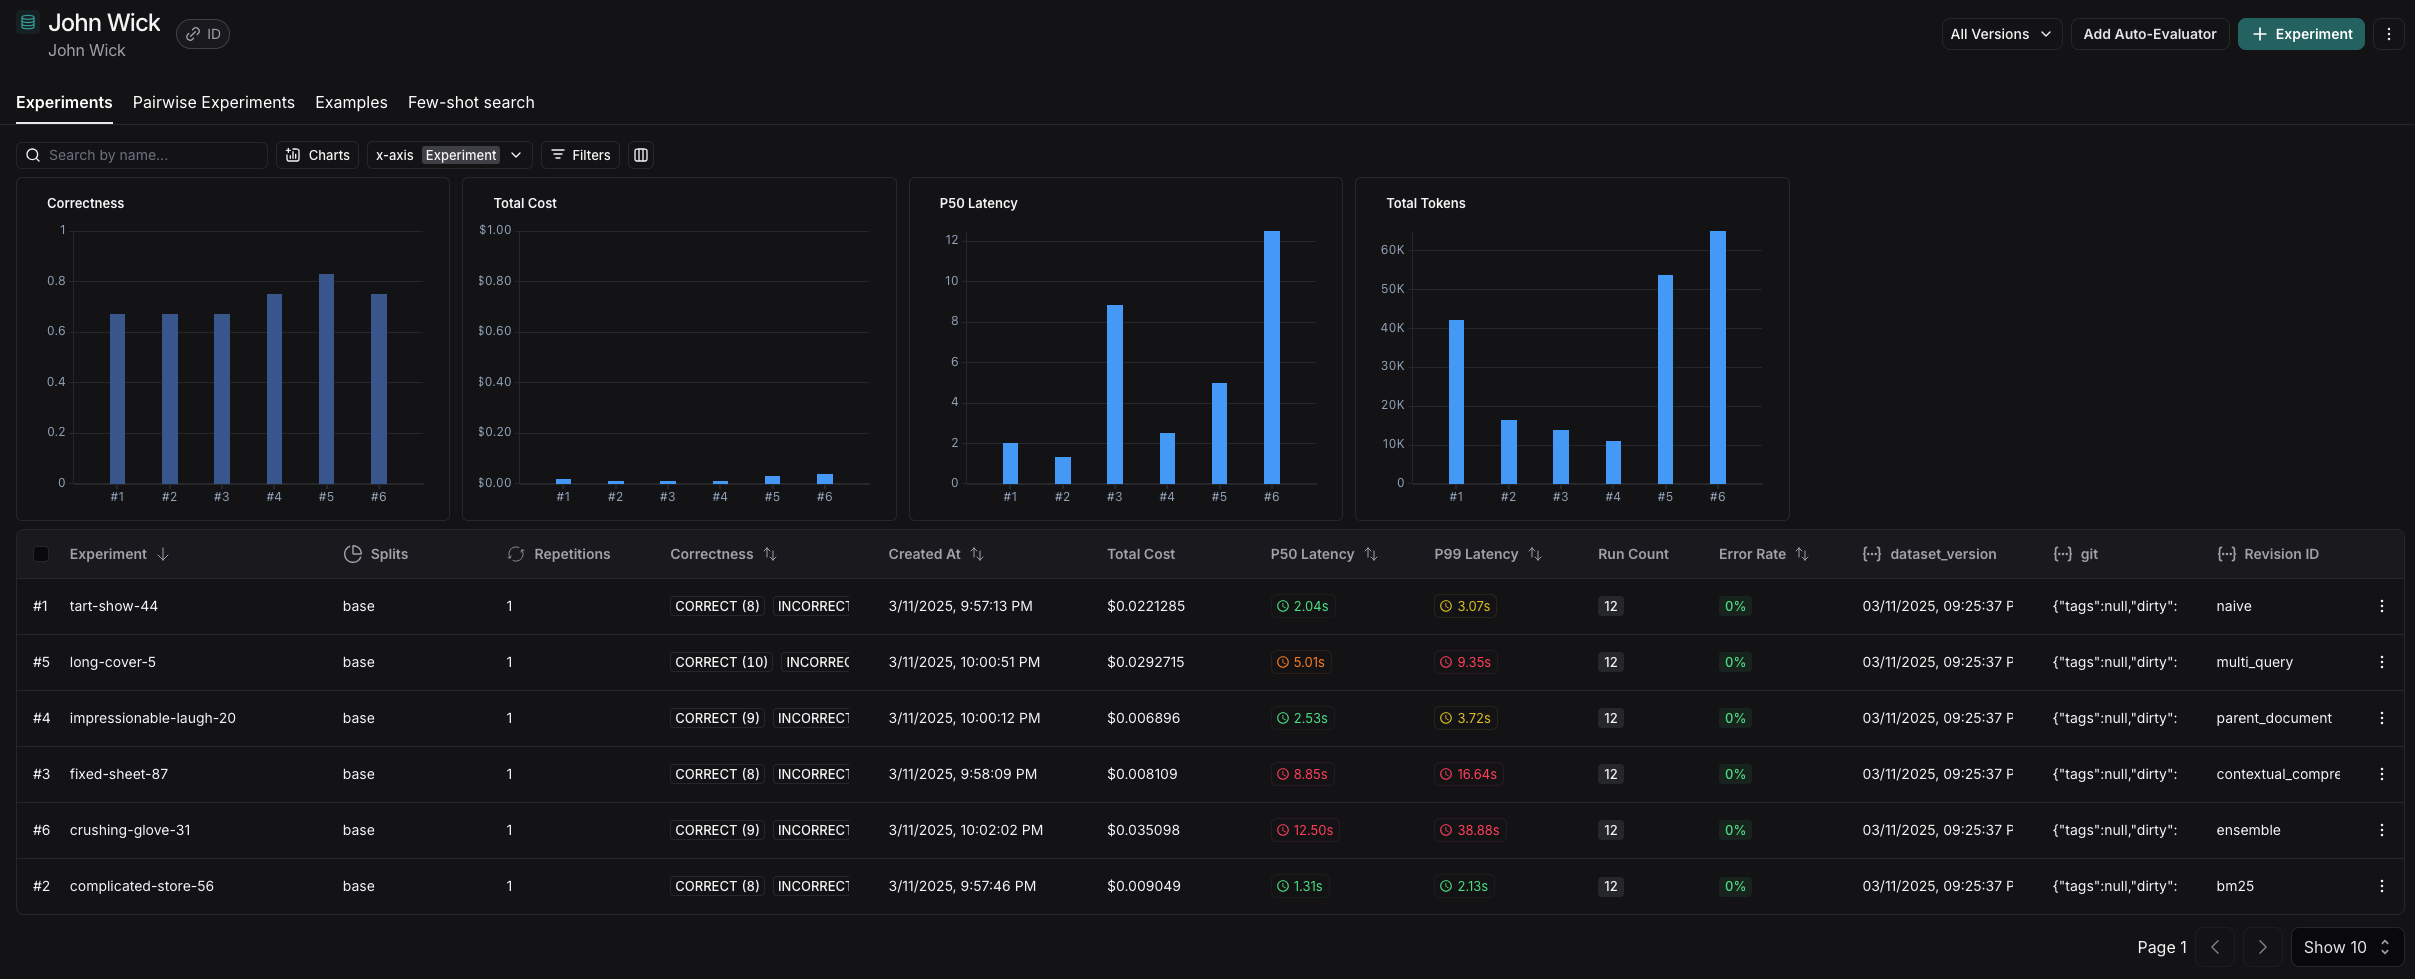

In [175]:
from IPython.display import Image
Image(filename='johnwick_langsmith_eval.png') 

In [174]:
naive_result["p50_latency"] = 2.04
naive_result["total_cost"] = 0.0221285
naive_result["correctness"] = str(round(8 / 12 * 100)) + "%"

bm25_result["p50_latency"] = 1.31
bm25_result["total_cost"] = 0.009049
bm25_result["correctness"] = str(round(8 / 12 * 100)) + "%"

contextual_compression_result["p50_latency"] = 8.85 - 6 # subtract ratelimit sleep(6)
contextual_compression_result["total_cost"] = 0.008109
contextual_compression_result["correctness"] = str(round(8 / 12 * 100)) + "%"

parent_document_result["p50_latency"] = 2.53
parent_document_result["total_cost"] = 0.006896
parent_document_result["correctness"] = str(round(9 / 12 * 100)) + "%"

multi_query_result["p50_latency"] = 5.01
multi_query_result["total_cost"] = 0.0292715
multi_query_result["correctness"] = str(round(10 / 12 * 100)) + "%"

ensemble_result["p50_latency"] = 12.50 - 6 # subtract ratelimit sleep(6)
ensemble_result["total_cost"] = 0.035098
ensemble_result["correctness"] = str(round(9 / 12 * 100)) + "%"

In [173]:
import pandas as pd
df = pd.DataFrame([
    naive_result,
    bm25_result,
    contextual_compression_result,
    parent_document_result,
    multi_query_result,
    ensemble_result
])
df

,name,context_recall,faithfulness,factual_correctness(mode=f1),answer_relevancy,context_entity_recall,noise_sensitivity(mode=relevant),p50_latency,total_cost,correctness
0,naive,0.7819,0.9012,0.3933,0.7997,0.5676,0.4017,2.04,0.022128,67%
1,bm25,0.4778,0.7597,0.4517,0.8848,0.5229,0.1692,1.31,0.009049,67%
2,contextual compression,0.6694,0.7830,0.3800,0.7975,0.4388,0.3196,2.85,0.008109,67%
3,parent document,0.5962,0.7150,0.4033,0.8872,0.4771,0.3248,2.53,0.006896,75%
4,multi query,0.7986,0.8264,0.4775,0.7906,0.5282,0.3148,5.01,0.029271,83%
5,ensemble,0.9236,0.8027,0.3675,0.7930,0.6084,0.5833,6.50,0.035098,75%


## Comparative Analysis

For the John Wick review data, the multi query retrieval method stands out as the most effective approach. With the highest correctness score of 83% and strong performance across key metrics, it demonstrates superior ability to retrieve relevant information despite its higher total cost ($0.029271) and higher p50 latency (5.01s). While ensemble retrieval shows impressive context recall (0.9236) and noise sensitivity (0.6084), multi query retrieval delivers better factual correctness (0.4775) and answer relevancy (0.7906). This suggests that the method of generating multiple query variations for the same question helps capture the diverse aspects of John Wick reviews, which contain varied opinions and details about different movies in the franchise. The multi query approach effectively handles the nuanced information in movie reviews by exploring different semantic angles of the same question, making it particularly well-suited for this domain where information can be subjective and multifaceted.

We should append a disclaimer that the correct choice depends on the system requirements. For example, in a system that is sensitive to latency and cost, we would rule out multi-query and ensemble methods, and could consider parent-document as it performs with the highest correctness, lowest cost, and reasonable latency, additionally out of the remaining options it has the highest answer relevancy.

